# Google Stock Price LSTM
### By Mojisoluwa Awe

In this notebook I will be exmaining stock price data for Google from 2004 to 2024, leveraging a dataset I found on Kaggle. First, I will go through some Exploratory Data Analysis to gain a better understanding of the data before building and examining a LSTM model to predict the Closing Price of the stock.

If you have any suggestions or comments please feel free to reach out!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm

In [13]:
df = pd.read_csv('GOOGL_2004-08-01_2024-12-18.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.501941,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.700670,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.727849,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.614895,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.643072,183772044


In [14]:
df['Date'] = pd.to_datetime(df.Date)

In [15]:
df['Daily_Return'] = df['Close'].pct_change() * 100

In [47]:
df['Daily_Change'] = df['Close'] - df['Open']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5118 entries, 0 to 5117
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5118 non-null   datetime64[ns]
 1   Open          5118 non-null   float64       
 2   High          5118 non-null   float64       
 3   Low           5118 non-null   float64       
 4   Close         5118 non-null   float64       
 5   Adj Close     5118 non-null   float64       
 6   Volume        5118 non-null   int64         
 7   Daily_Return  5117 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 320.0 KB


In [19]:
#df.isnull().sum()

In [20]:
#df.dropna()
#df.drop_duplicates()
#df.head()

## EDA
In this section we will be examining and visualizing the dataset. From reading the description from Kaggle I know this is a dataset containing a limited amount of data including date, opening price, highest price of the day, lowest price of the day, closing price, closing price after adjustments, and the number of shares traded that day (volume).

In [21]:
print('Earliest Date: ', df['Date'].min())
print('Latest Date: ' , df['Date'].max())

Earliest Date:  2004-08-19 00:00:00
Latest Date:  2024-12-17 00:00:00


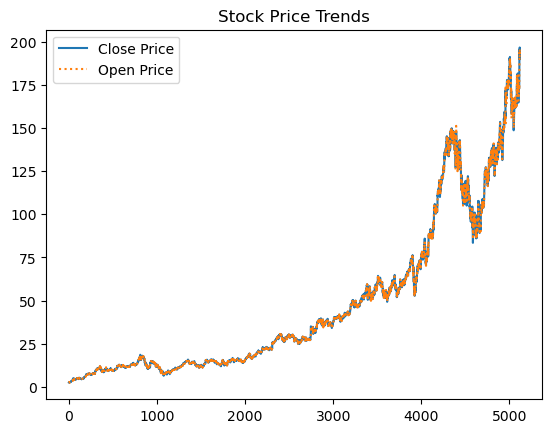

In [22]:
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['Open'], label='Open Price', linestyle = 'dotted')
plt.title('Stock Price Trends')
plt.legend()

Text(0.5, 1.0, 'Distribution of Daily Returns (%)')

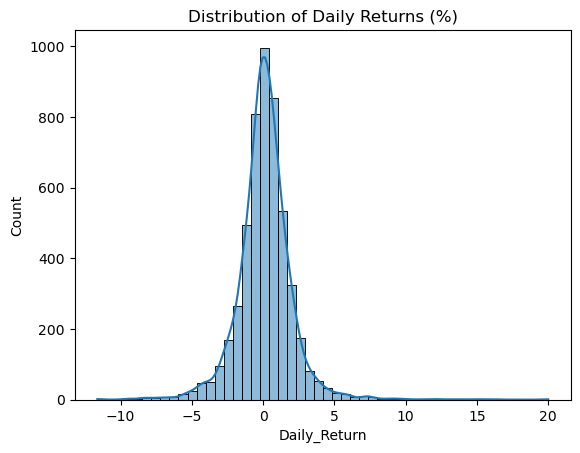

In [51]:
sns.histplot(df['Daily_Return'], bins=50, kde=True)
plt.title('Distribution of Daily Returns (%)')

Text(0.5, 1.0, 'Distribution of Closing Prices')

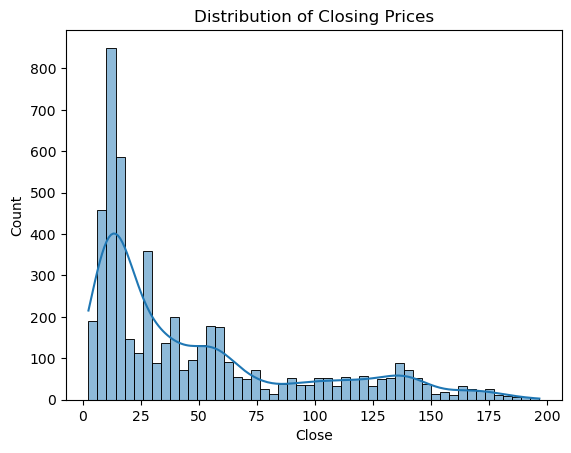

In [52]:
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Closing Prices')

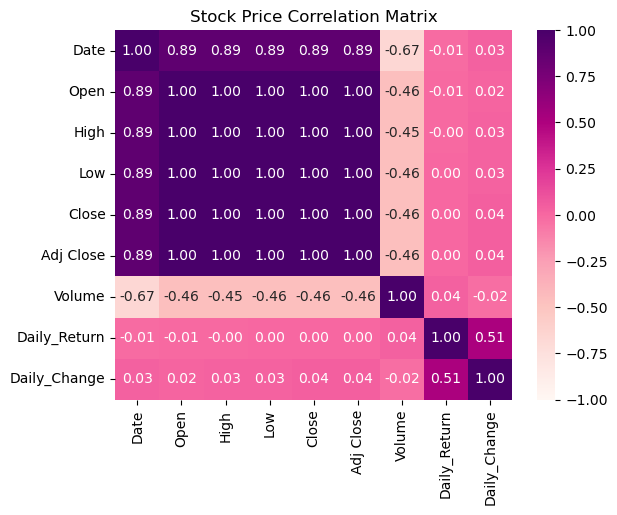

In [48]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'RdPu', fmt = '.2f', vmin = -1, vmax = 1)
plt.title('Stock Price Correlation Matrix')
plt.show()

From this correlation matrix we can see that there is a strong correlation between between the closing price and all of the metrics (Date, Open, High, Low), aside from Volume. This is most likely due to the fact that the price of a stock may fluctuate for various reasons that don't directly affect the volume. For example, a stock price may rise due to a new innovation or technology release, but that doesn't necessarily mean there will be sn impact to trading volume.

In [23]:
df = df.sort_values(by = 'Date')
#df.head()

In [49]:
scaler = MinMaxScaler()
features = df[['Open', 'High', 'Low', 'Daily_Change', 'Volume']].values
target = df['Close'].values.reshape(-1, 1)

features = scaler.fit_transform(features)
target = scaler.fit_transform(target)

I chose to normalize the data due to the difference in ranges between certain values, such as the stock price, daily return, and volume. The stock prices range from 0 to 200 dollars, the daily returns are a percentage between 0 and 100, and the volume is the millions.

## Sequences

I'm creating sliding window sequences to make this time series prediction. I'm setting the train window to 7, this means that in order to make a prediction, the model will be using 7 time steps (7 days of data with the Open, High, Low, Daily Change, Year, and Volume) to predict the next value (Closing price of the 8th day).

In [50]:
train_window = 7

def create_sequences(features, target, train_window):
    sequences = []
    
    for i in range(len(features) - train_window):
        input_seq = features[i : i + train_window]
        
        label = target[i + train_window]
        
        sequences.append((input_seq, label))
    return sequences
    
data = create_sequences(features, target, train_window)

## Training & Testing Split

In [51]:
test_size = 0.3
split_index = int(len(data) * (1 - test_size))

train = data[:split_index]
test = data[split_index:]

In [52]:
train_sequences = torch.tensor([seq for seq, _ in train], dtype = torch.float32)
train_labels = torch.tensor([label for _, label in train], dtype = torch.float32)

batch_size = 32
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

## Building the LSTM

In this part if the code, we'll be taking the sequence of features then processing them through the layers of the LSTM to make a predicition for each sequence. Here the sequences will be processed through the LSTM layers to make each prediction.

In the forward pass the hidden and cell states are initialized with zeros, then they processes the input through the LSTM. Following this, the last output is passed through a linear layer to give us the prediction.

In [53]:
class LSTM(nn.Module):
    def __init__(self, input_size = 5, hidden_layer_size = 100, output_size = 1, num_layers = 1):
        super(LSTM, self).__init__()
        
        self.hidden_layer_size = hidden_layer_size
        
        self.num_layers = num_layers
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first = True, dropout = 0.2 if num_layers > 1 else 0)
        # fully connected layer
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(input_seq.device)
        
        lstm_out, (hidden, cell) = self.lstm(input_seq, (h0, c0))
        
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [54]:
model = LSTM(input_size = 5, hidden_layer_size = 128, output_size = 1, num_layers = 2)

# loss and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Model Training

In [55]:
epochs = 50
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for seq, labels in tqdm(train_loader):
        seq = seq.view(seq.size(0), seq.size(1), -1)
        labels = labels.view(-1, 1)
        
        optimizer.zero_grad()
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        
        single_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 5)
        
        optimizer.step()
        
        epoch_loss += single_loss.item()

    scheduler.step()
    
    average_loss = epoch_loss / len(train_loader)
    print(f'epoch {epoch+1}/{epochs}, Loss: {average_loss:.10f}')

  0%|          | 0/112 [00:00<?, ?it/s]

epoch 1/50, Loss: 0.0015021642


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 2/50, Loss: 0.0000470525


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 3/50, Loss: 0.0000422793


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 4/50, Loss: 0.0000364649


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 5/50, Loss: 0.0000342383


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 6/50, Loss: 0.0000282347


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 7/50, Loss: 0.0000273761


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 8/50, Loss: 0.0000277949


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 9/50, Loss: 0.0000259238


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 10/50, Loss: 0.0000274060


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 11/50, Loss: 0.0000202714


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 12/50, Loss: 0.0000182541


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 13/50, Loss: 0.0000185530


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 14/50, Loss: 0.0000171748


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 15/50, Loss: 0.0000172038


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 16/50, Loss: 0.0000178603


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 17/50, Loss: 0.0000183517


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 18/50, Loss: 0.0000180003


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 19/50, Loss: 0.0000179878


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 20/50, Loss: 0.0000186157


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 21/50, Loss: 0.0000170696


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 22/50, Loss: 0.0000161684


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 23/50, Loss: 0.0000166421


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 24/50, Loss: 0.0000172904


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 25/50, Loss: 0.0000170234


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 26/50, Loss: 0.0000167004


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 27/50, Loss: 0.0000160824


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 28/50, Loss: 0.0000167070


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 29/50, Loss: 0.0000168492


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 30/50, Loss: 0.0000165639


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 31/50, Loss: 0.0000166220


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 32/50, Loss: 0.0000172436


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 33/50, Loss: 0.0000166737


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 34/50, Loss: 0.0000176677


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 35/50, Loss: 0.0000174805


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 36/50, Loss: 0.0000166714


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 37/50, Loss: 0.0000169491


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 38/50, Loss: 0.0000169243


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 39/50, Loss: 0.0000164700


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 40/50, Loss: 0.0000181403


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 41/50, Loss: 0.0000163321


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 42/50, Loss: 0.0000168996


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 43/50, Loss: 0.0000171134


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 44/50, Loss: 0.0000169037


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 45/50, Loss: 0.0000167413


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 46/50, Loss: 0.0000162386


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 47/50, Loss: 0.0000162703


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 48/50, Loss: 0.0000169426


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 49/50, Loss: 0.0000170356


  0%|          | 0/112 [00:00<?, ?it/s]

epoch 50/50, Loss: 0.0000165555


In [57]:
model.eval()

test_sequences = torch.tensor([seq for seq, _ in test], dtype = torch.float32)
test_labels = torch.tensor([label for _, label in test], dtype = torch.float32)

with torch.no_grad():
    predictions = model(test_sequences).view(-1)

In [58]:
print('MAE: ', mean_absolute_error(test_labels, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(test_labels, predictions)))

MAE:  0.03391705
RMSE:  0.047693595


/var/folders/j6/dnffdgcd71z4km6khzwmss5w0000gn/T/ipykernel_1819/3184958807.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


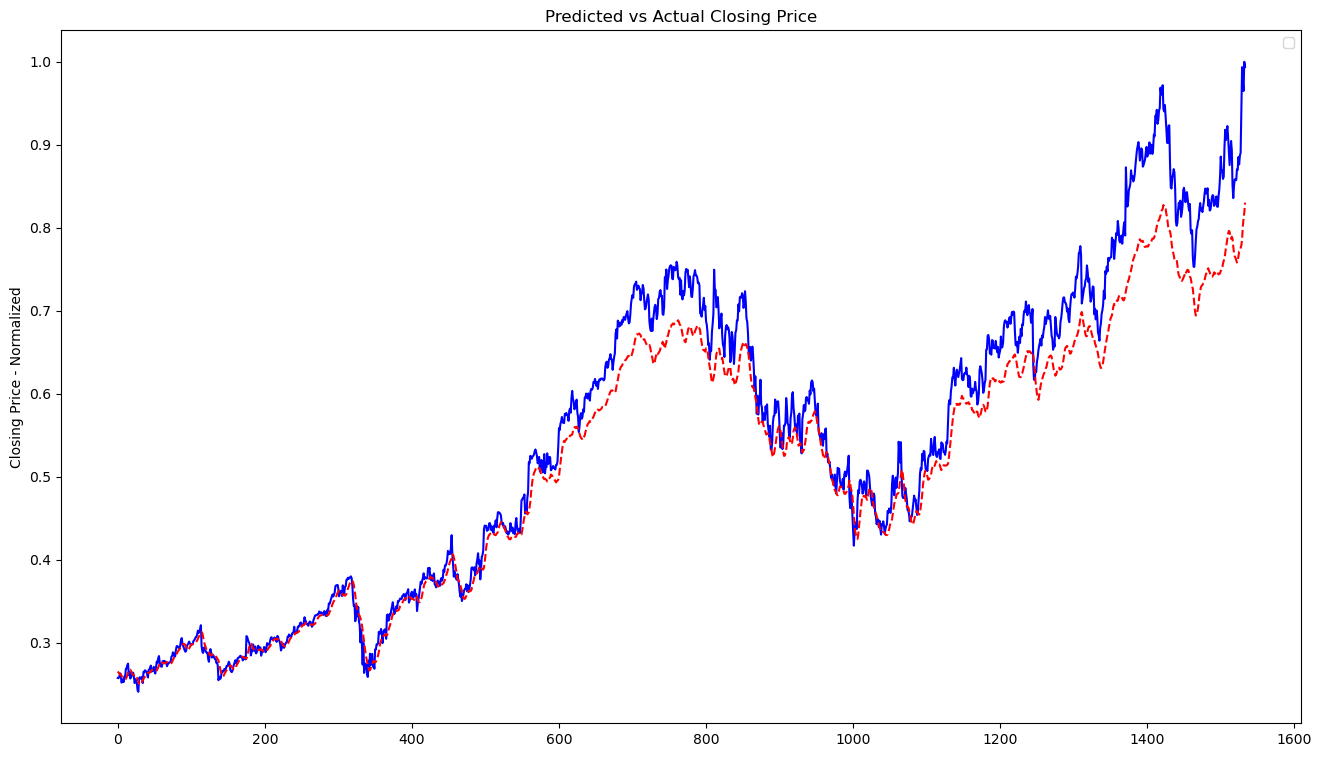

In [64]:
plt.figure(figsize = (16, 9))
plt.plot(test_labels, color = 'blue')
plt.plot(predictions, color = 'red', linestyle = 'dashed')
plt.title('Predicted vs Actual Closing Price')
plt.legend()
plt.ylabel('Closing Price - Normalized')
plt.show()

The model does a pretty good job of predicting close price, especially from the 0-600 range. Yet, the model does underperform at certain points, the 600-800 and 1200-1600. It appears that when there are moments of extreme volatility, it's harder for the model to adjust, opposed to more steady performances. I'm going to make an attempt to combat this through feature engineering and adjusting the models complexity.

In [67]:
df['Week_Volatility'] = df['Close'].rolling(window=7).std().fillna(0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Daily_Change,Week_Volatility
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.501941,893181924,NaN,0.008508,0.0
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.700670,456686856,0.079430,0.182682,0.0
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.727849,365122512,0.010064,-0.033784,0.0
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.614895,304946748,-0.041408,-0.159410,0.0
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.643072,183772044,0.010776,0.026026,0.0
